In [1]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

from scipy.interpolate import interp1d


import cProfile

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14


Error:  name 'physics' is not defined


In [2]:
# Aluminuma
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = 8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

Ti_eV = 2 
Te_eV = 10

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

####
R = 30*rs
rmin = rs/1000
ignore_vxc = True

aa_kwargs = {'initialize':True, 'gradient_correction':None, 'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin': rmin,'Npoints':600,
             'name':name, 'ignore_vxc':ignore_vxc, 'fixed_Zstar':False, 'iet_R_over_rs':R/rs, 'iet_N_bins':5000, 'use_full_ne_for_nf':False}
aa = NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aa_kwargs)

________________________
Generating NPA
Using More TF fit for initial Zstar = 4.052
	Intializing grid
	Creating Integral Equation Solver
Intialized Potentials and Densities


In [4]:
%%time
aa.solve_TF(verbose=True, picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-7)
aa.set_uii_eff()
aa.iet.HNC_solve(iters_to_wait=1e5, tol=1e-12, verbose=False, num_iterations=1e5)
aa.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(aa.grid.xs)
aa.make_ρi()

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     1.7270, change: 2.4464e+00 (converged=False)
	φe Err = -1.056e-11, φe change =  7.330e-01
	ne Err =  4.995e-01, ne change =  2.774e-03
	Q =  0.000e+00 ->  1.451e+00, 
	Zstar guess =  9.434e+00. Current Zstar:  5.128e+00 (converged=False)
	Change =  2.088e+00
__________________________________________
TF Iteration 1
	mu =     1.3235, change: 2.3365e-01 (converged=False)
	φe Err = -1.136e-11, φe change =  6.328e-02
	ne Err =  3.545e-01, ne change =  1.796e-03
	Q =  1.451e+00 ->  1.375e+00, 
	Zstar guess =  7.800e+00. Current Zstar:  5.663e+00 (converged=False)
	Change =  2.567e-01
__________________________________________
TF Iteration 2
	mu =     1.2048, change: 8.9711e-02 (converged=False)
	φe Err = -6.251e-12, φe change =  3.146e-02
	ne Err =  2.768e-01, ne change =  1.350e-03
	Q =  1.375e+00 ->  1.419e+00, 
	Zstar guess =  7.134e+00. Current

NameError: name 'npa' is not defined

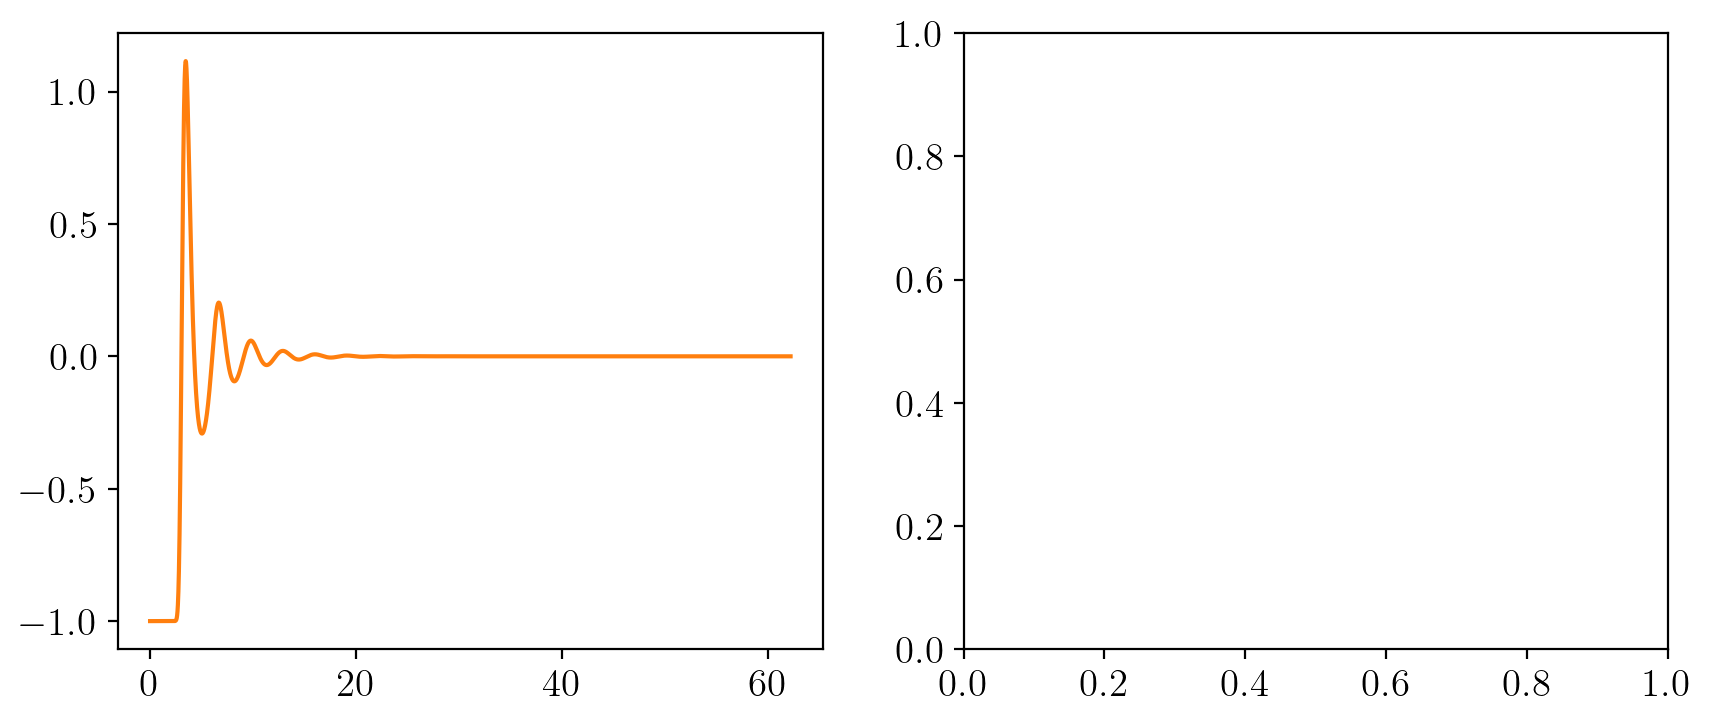

In [8]:
fig, axs  = plt.subplots(1,2,figsize=(10,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# short_distance_weight = np.exp(-(0.08*npa.kTF*npa.grid.xs)**4)
for ax in axs:
    # ax.plot(npa.iet.r_array*rs, npa.iet.h_r_matrix[0,0], color=colors[0], label=r"NPA: $u_Y$")
    # ax.plot(npa.grid.xs, npa.gii-1, color=colors[0], label=r"NPA: $u_Y$")
    # ax.plot(npa_2.grid.xs, npa_2.gii-1,'--', color=colors[0], label=r"NPA: $u_{AA}$",zorder=10)
    ax.plot(aa.iet.r_array*rs, aa.iet.h_r_matrix[0,0],color=colors[1],  label=r"$u_{AA}$")
    # ax.plot(npa.grid.xs, short_distance_weight*(npa.gii-1),'--',color=colors[3],  label=r"$u_Y$ damped")
    			

    # ax.plot(aa.grid.xs, aa.gii-1,'--',color=colors[3],  label=r"$u_Y$")
    ax.axvline(npa.iet.r_array[-1]*rs,color='k')
    
ax = axs[0]
ax.set_xlabel(r"$r/r_i$",fontsize=12)
ax.set_ylabel("h(r)",fontsize=12)
ax.set_xlim(0,3*rs)

ax = axs[1]
ax.set_xlabel(r"$r/r_i$",fontsize=12)
ax.set_ylabel("h(r)",fontsize=12)
ax.set_xscale('log')
ax.set_xlim(0.5,None)
ax.set_yscale('symlog', linthresh=1e-6)
for ax in axs:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)


plt.tight_layout()



(<Figure size 4000x1600 with 2 Axes>,
 array([<Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$4 \\pi r^2 n_e(r) $ [A.U.]'>,
        <Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$n_e$ [A.U.]'>],
       dtype=object))

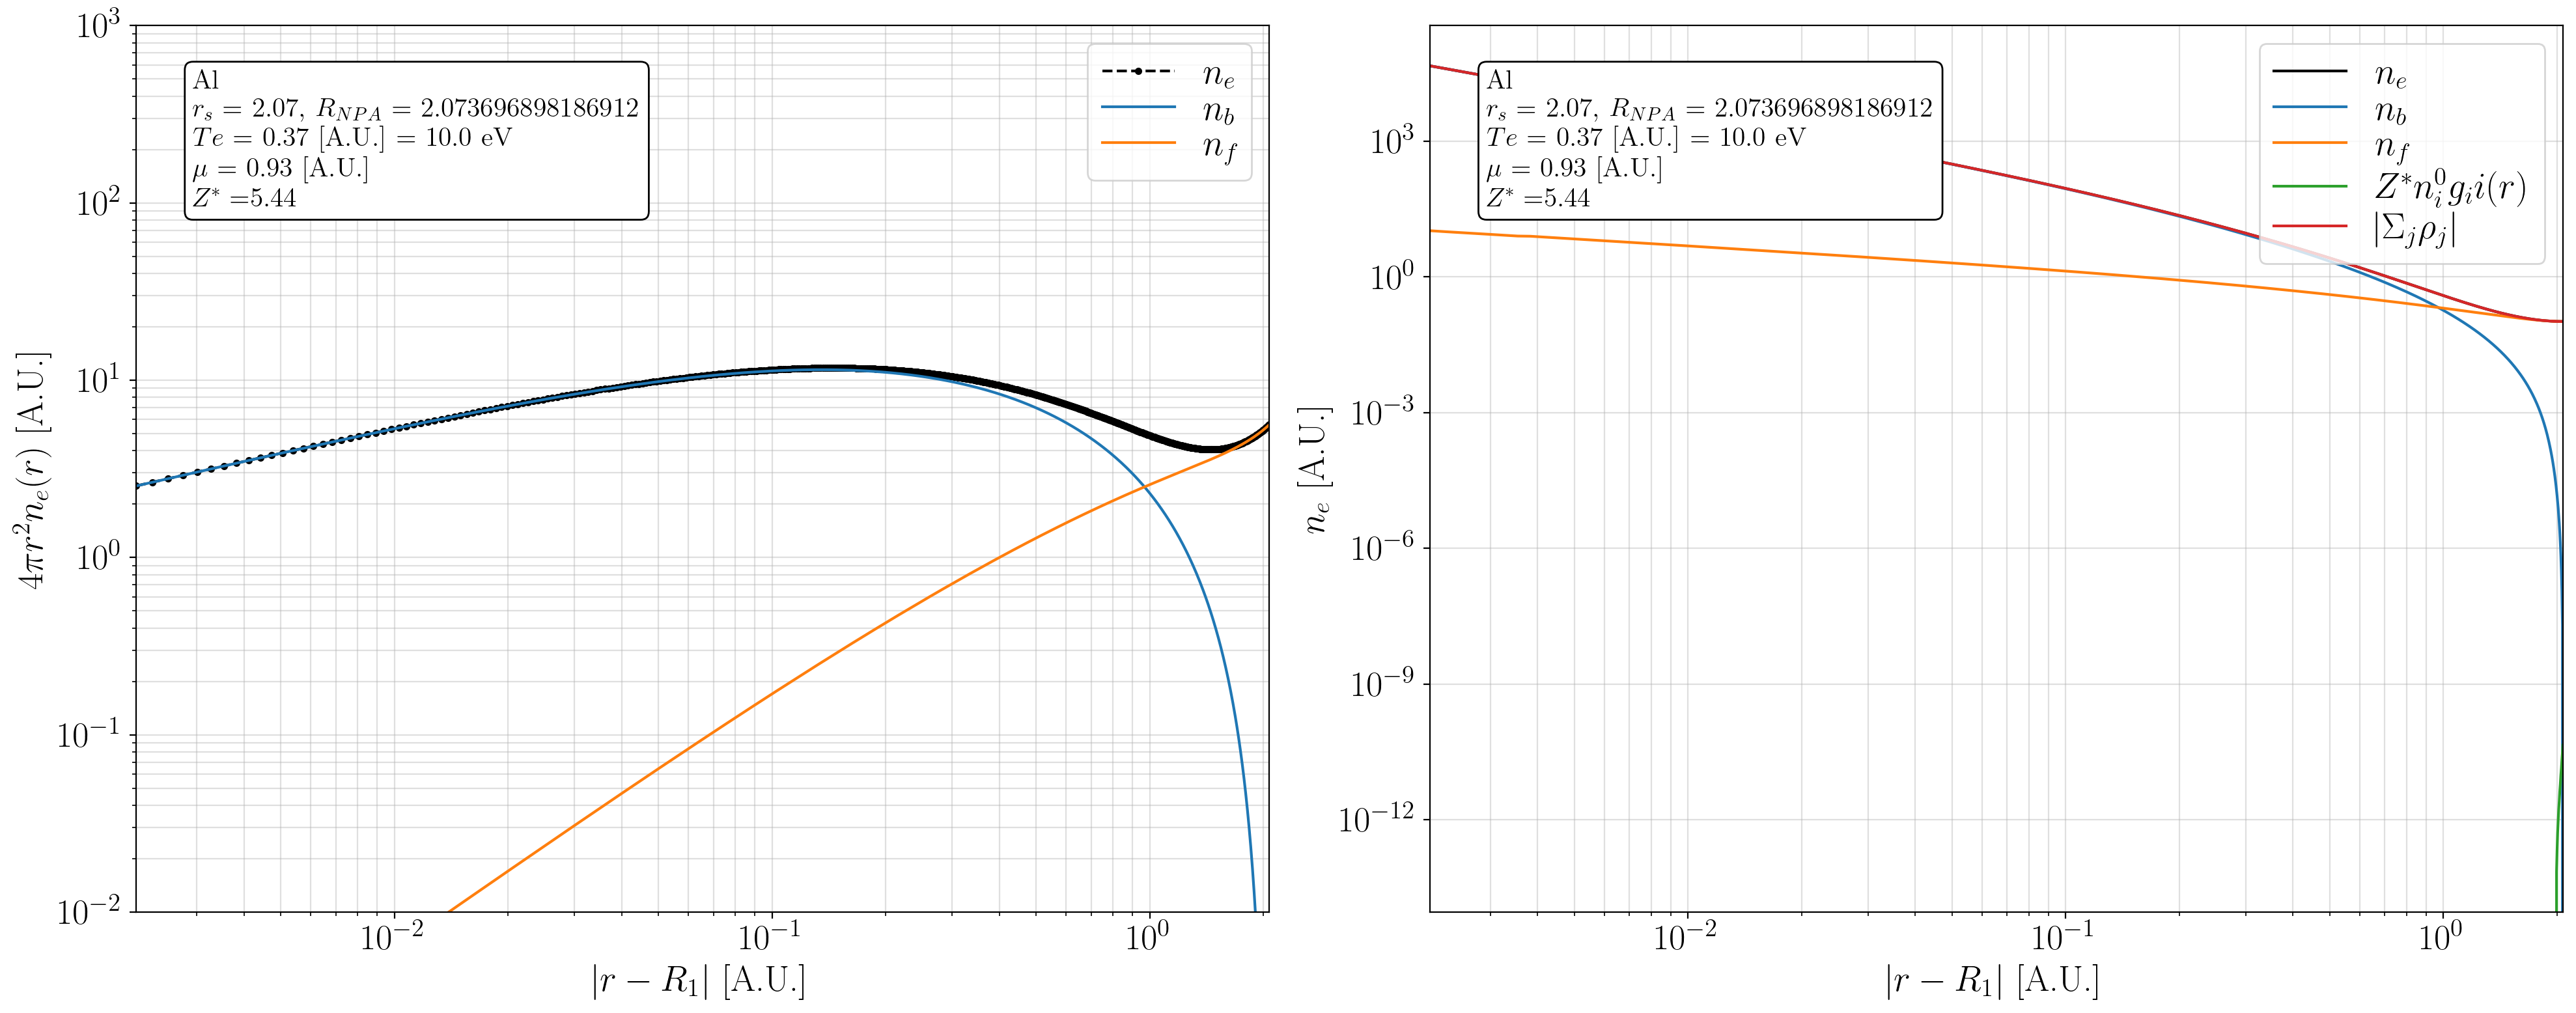

In [9]:
aa.make_plot_bound_free()

(<Figure size 4000x1600 with 2 Axes>,
 array([<Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$4 \\pi r^2 n_e(r) $ [A.U.]'>,
        <Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$4 \\pi r^2 n_e(r) $ [A.U.]'>],
       dtype=object))

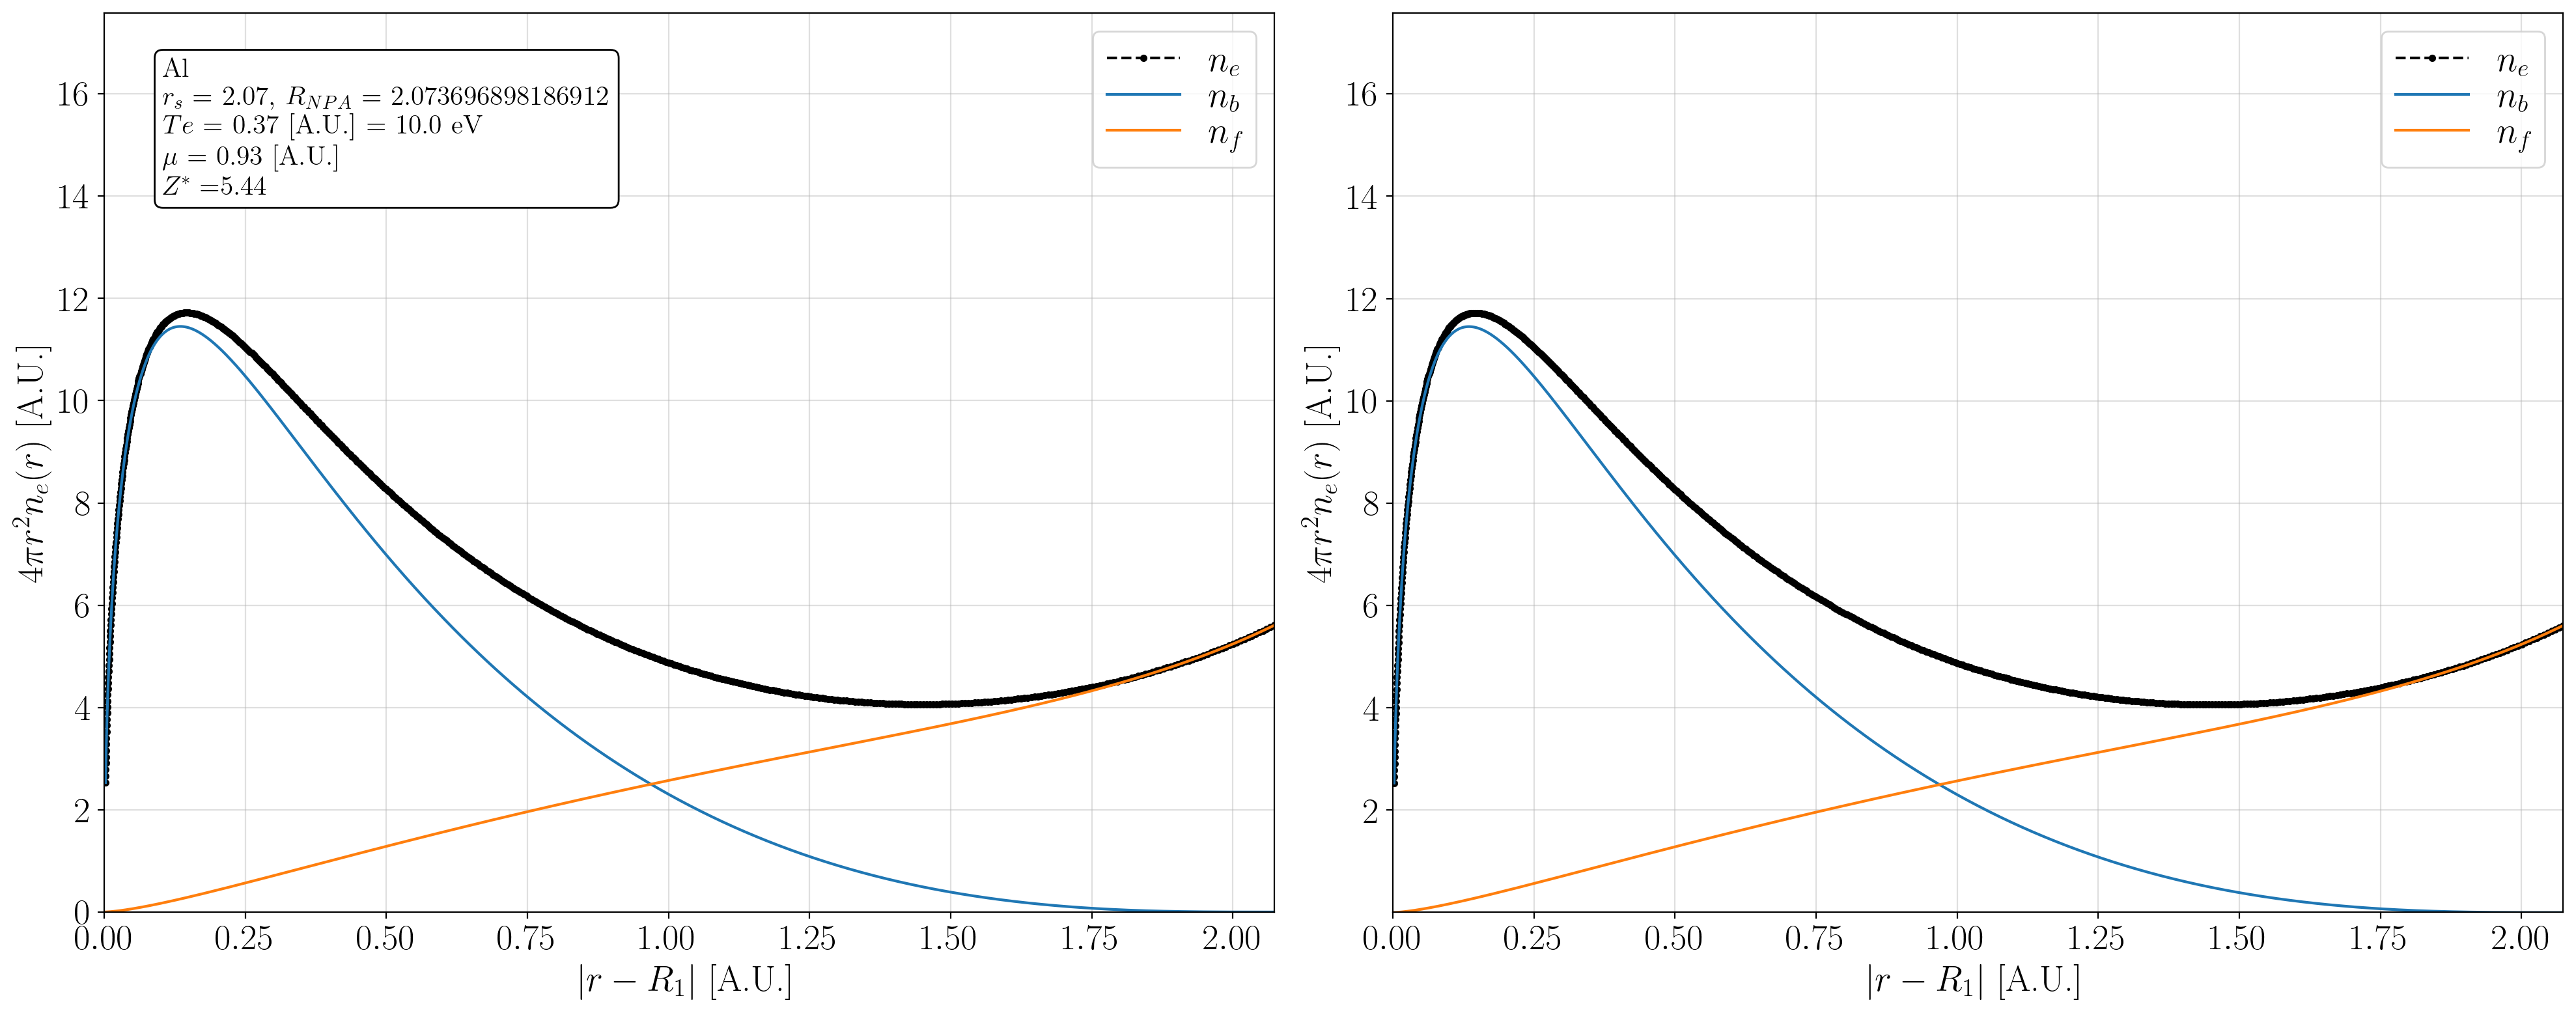

In [10]:
aa.make_charge_plot()

### Compare with Cleroin 2015 OFDFT

In [11]:
from pandas import read_csv

JC_2015_data = read_csv("Al_Clerouin_2015.txt", delim_whitespace=True, header=1)
JC_2015_data

,k[1/Ang],S_ii(k)
0,0.7108,0.02663
1,1.1760,0.03390
2,1.6420,0.05206
3,2.1150,0.09080
4,2.5880,0.18640
5,3.0520,0.43460
6,3.5120,1.12700
7,3.9890,1.77400
8,4.4580,1.36700
9,4.9260,0.98060


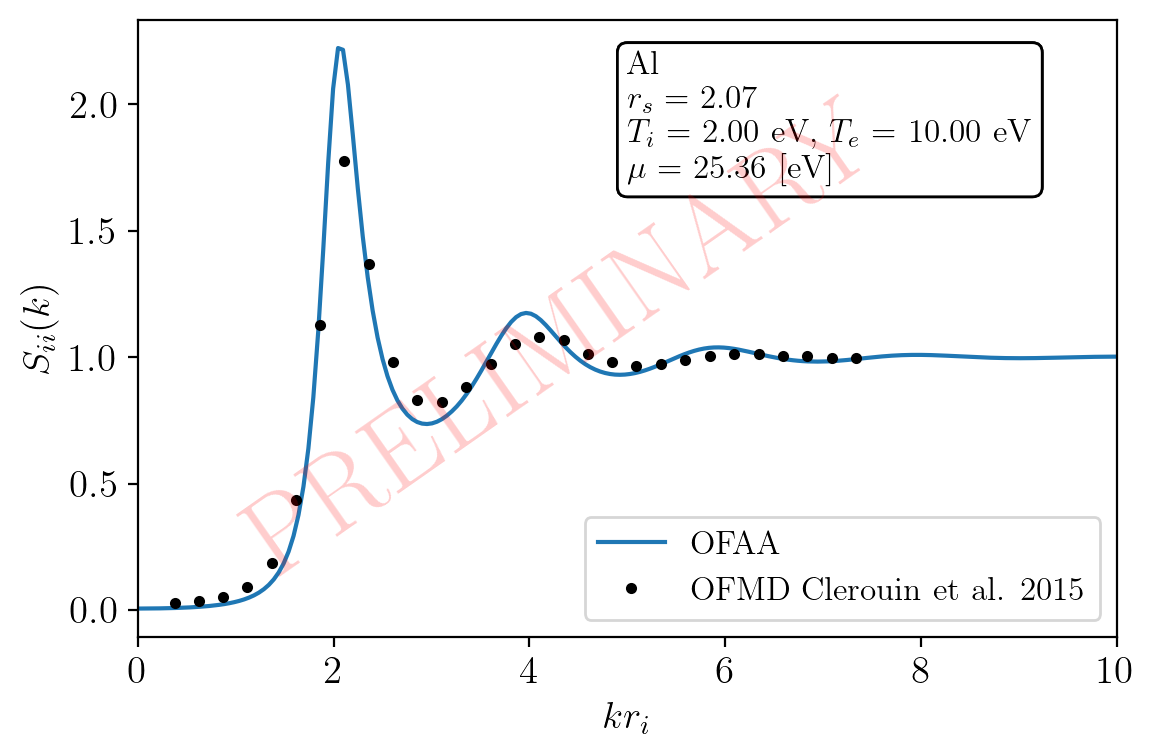

In [14]:
fig, ax = plt.subplots()

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(aa.iet.k_array/rs, aa.iet.S_k_matrix[0,0],'-', label="OFAA")
ax.plot(JC_2015_data['k[1/Ang]']/Angstrom_to_AU, JC_2015_data['S_ii(k)'],'k.', label="OFMD Clerouin et al. 2015" )

# make textbox
text = ("{0}\n".format(aa.name)+ 
    r"$r_s$ = " + "{0}\n".format(np.round(aa.rs,2))  +
        r"$T_i$ = " + "{0:0.2f} eV,   ".format(aa.Ti*AU_to_eV) +
        r"$T_e$ = " + "{0:0.2f} eV\n".format(aa.Te*AU_to_eV) +
        r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

props = dict(boxstyle='round', facecolor='w')
ax.text(0.5,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)

# make textbox
text = ("{0}\n".format(aa.name)+ 
    r"$r_s$ = " + "{0}\n".format(np.round(aa.rs,2))  +
        r"$T_i$ = " + "{0:0.2f} eV,   ".format(aa.Ti*AU_to_eV) +
        r"$T_e$ = " + "{0:0.2f} eV\n".format(aa.Te*AU_to_eV) +
        r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

props = dict(boxstyle='round', facecolor='w')
ax.text(0.5,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)
ax.text(0.1,0.1, 'PRELIMINARY', rotation=35,color='r',alpha=0.2,fontsize=40, transform=ax.transAxes)#, verticalalignment='top', horizontalalignment='left')

ax.set_xlim(0,10)
ax.set_xlabel(r"$k r_i$")
ax.set_ylabel(r"$S_{ii}(k)$")
ax.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig("Sii_Clerouin.png")